# Ensemble Stacking For Cardboard Box Defect Detection Using ResNet-50 and Inception V3

Authors: 
- Evan Santosa (evan.santosa001@binus.ac.id)
- Henry Wunarsa (henry.wunarsa@binus.ac.id)
- Alexander Agung Santoso Gunawan (aagung@binus.edu)
- Rilo Chandra Pradana (rilo.pradana@binus.edu)

In [1]:
# Use GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
import tensorflow_addons as tfa

### A. Data Preparation

The data are gathered from:
https://universe.roboflow.com/meryem-meryem-8twxl/carton-can-detection/dataset/1

In [3]:
import pandas as pd
import os

In [4]:
os.chdir("../")

In [5]:
CLASSES = {
    "carton box": "0",
    "opened carton box": "1",
    "wet carton box": "2",
    "cracked carton box": "3"
}

In [6]:
def assign_label(row, CLASSES):
    for class_name, label in CLASSES.items():
        if row[class_name]:
            return label 
        
    return None

In [7]:
def load_dataset(split, BASE_DIR = "data", FILE_NAME = "_classes.csv", CLASSES = CLASSES):
    csv_path = os.path.join(BASE_DIR, split, FILE_NAME)

    df = pd.read_csv(csv_path)

    df["is_multiple_class"] = (df["carton box"] + df["cracked carton box"] + df["opened carton box"] + df["wet carton box"]) > 1
    
    df = df[~df["is_multiple_class"]]

    df["filename"] = df["filename"].apply(lambda x: os.path.join(BASE_DIR, split, x))
    df["label"] = df.apply(assign_label, axis = 1, args = (CLASSES, )) 

    return df[["filename", "label"]]

In [8]:
train_df = load_dataset("train")
valid_df = load_dataset("valid")
test_df = load_dataset("test")

In [9]:
train_category_count = train_df["label"].value_counts().reset_index()
train_category_count.columns = ["label", "count"]
train_category_count["label"] = train_category_count["label"].map({v: k for k, v in CLASSES.items()})
train_category_count.sort_values(by = "count", ascending = False, inplace = True)
train_category_count

,label,count
0,carton box,1254
1,cracked carton box,984
2,opened carton box,312
3,wet carton box,270


In [10]:
valid_category_count = valid_df["label"].value_counts().reset_index()
valid_category_count.columns = ["label", "count"]
valid_category_count["label"] = valid_category_count["label"].map({v: k for k, v in CLASSES.items()})
valid_category_count.sort_values(by = "count", ascending = False, inplace = True)
valid_category_count

,label,count
0,carton box,113
1,cracked carton box,98
2,opened carton box,32
3,wet carton box,22


In [11]:
test_category_count = test_df["label"].value_counts().reset_index()
test_category_count.columns = ["label", "count"]
test_category_count["label"] = test_category_count["label"].map({v: k for k, v in CLASSES.items()})
test_category_count.sort_values(by = "count", ascending = False, inplace = True)
test_category_count

,label,count
0,carton box,67
1,cracked carton box,55
2,wet carton box,6
3,opened carton box,4


### B. Data Preprocessing

##### 1. Combining Validation and Testing Dataset

Since testing dataset have very low amount of wet carton box and opened carton box class, the validation and testing dataset will be combined to increase accuracy stability.

In [12]:
test_df = pd.concat([valid_df, test_df])

In [13]:
test_category_count = test_df["label"].value_counts().reset_index()
test_category_count.columns = ["label", "count"]
test_category_count["label"] = test_category_count["label"].map({v: k for k, v in CLASSES.items()})
test_category_count.sort_values(by = "count", ascending = False, inplace = True)
test_category_count

,label,count
0,carton box,180
1,cracked carton box,153
2,opened carton box,36
3,wet carton box,28


##### 2. Image Augmentation

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.4, 1.5],
    zoom_range = 0.3,
    shear_range = 0.2,
    fill_mode = "nearest",
    validation_split = 0.2
)

In [15]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

### C. Exploratory Data Analysis (EDA)

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [17]:
def calculate_mean_rgb(df):
    rgb_dict = {}

    for label in df["label"].unique():
        subset = df[df["label"] == label]
        r_vals, g_vals, b_vals = [], [], []

        for file in subset["filename"]:
            img = Image.open(file).convert("RGB")
            img_np = np.array(img)
            
            r_vals.append(np.mean(img_np[:, :, 0]))
            g_vals.append(np.mean(img_np[:, :, 1]))
            b_vals.append(np.mean(img_np[:, :, 2]))

        rgb_dict[label] = {
            "R_mean": np.mean(r_vals),
            "G_mean": np.mean(g_vals),
            "B_mean": np.mean(b_vals)
        }

    return rgb_dict


In [18]:
all_df = pd.concat([train_df, valid_df, test_df])
rgb_results = calculate_mean_rgb(all_df)

In [19]:
label_to_name = {v: k for k, v in CLASSES.items()}
for label, values in rgb_results.items():
    class_name = label_to_name[label]
    print(f"{class_name}: R = {values['R_mean']:.2f}, G = {values['G_mean']:.2f}, B = {values['B_mean']:.2f}")

opened carton box: R = 207.11, G = 188.18, B = 169.19
wet carton box: R = 199.00, G = 181.99, B = 161.69
cracked carton box: R = 176.77, G = 161.78, B = 146.70
carton box: R = 214.55, G = 195.74, B = 175.55


In [20]:
def plot_rgb_means(rgb_results):
    labels = [label_to_name[label] for label in rgb_results]
    r_means = [rgb_results[label]["R_mean"] for label in rgb_results]
    g_means = [rgb_results[label]["G_mean"] for label in rgb_results]
    b_means = [rgb_results[label]["B_mean"] for label in rgb_results]

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots()
    ax.bar(x - width, r_means, width, label = "Red", color = "r")
    ax.bar(x, g_means, width, label = "Green", color = "g")
    ax.bar(x + width, b_means, width, label = "Blue", color = "b")

    ax.set_ylabel("Mean RGB Value")
    ax.set_title("Mean RGB per Class")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation = 15)
    ax.legend()

    plt.tight_layout()
    plt.show()

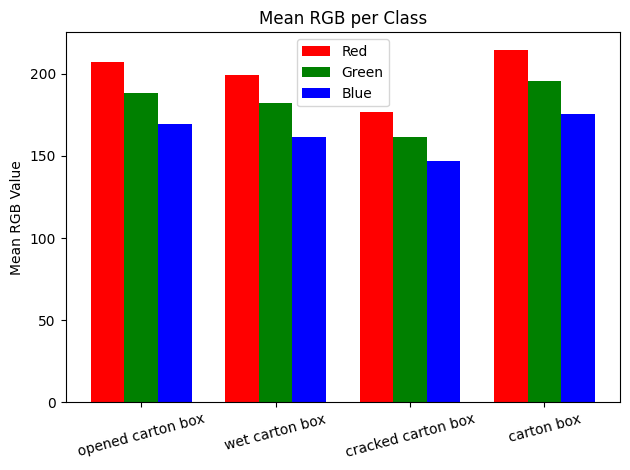

In [21]:
plot_rgb_means(rgb_results)

### D. Modeling

In [23]:
def split_data(train_datagen, train_df, test_datagen, test_df, SIZE = (224, 224)):
    train_set = train_datagen.flow_from_dataframe(
        train_df,
        x_col = "filename",
        y_col = "label",
        batch_size = 32,
        target_size = SIZE,
        shuffle = True,
        color_mode = "rgb",
        subset = "training"
    )   

    valid_set = train_datagen.flow_from_dataframe(
        train_df,
        x_col = "filename",
        y_col = "label",
        batch_size = 32,
        target_size = SIZE,
        shuffle = False,
        color_mode = "rgb",
        subset = "validation"
    )   

    test_set = test_datagen.flow_from_dataframe(
        test_df,
        x_col = "filename",
        y_col = "label",
        batch_size = 32,
        target_size = SIZE,
        shuffle = False,
        color_mode = "rgb"
    )

    return train_set, valid_set, test_set

In [24]:
train_set, valid_set, test_set = split_data(train_datagen, train_df, test_datagen, test_df, SIZE = (299, 299))

Found 2256 validated image filenames belonging to 4 classes.
Found 564 validated image filenames belonging to 4 classes.
Found 397 validated image filenames belonging to 4 classes.


##### 1. Baseline CNN 

In [25]:
cnn = tf.keras.models.Sequential()

# Convulational Layer 1
cnn.add(tf.keras.layers.Conv2D(
    filters = 32, 
    kernel_size = 3, 
    input_shape = [299, 299, 3], 
    kernel_regularizer = tf.keras.regularizers.l2(0.00005),
    padding = "same"
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())

# Pooling Layer 1
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size = 2, 
    strides = 2
))

# Convulational Layer 2
cnn.add(tf.keras.layers.Conv2D(
    filters = 32, 
    kernel_size = 3, 
    kernel_regularizer = tf.keras.regularizers.l2(0.00005),
    padding = "same"
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())

# Pooling Layer 2
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size = 2, 
    strides = 2
))

# Flatten Layer 
cnn.add(tf.keras.layers.Flatten())

# Fully Connected Layer 1
cnn.add(tf.keras.layers.Dense(
    units = 128,
    kernel_regularizer = tf.keras.regularizers.l2(0.00005)
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())


# Droput Layer
cnn.add(tf.keras.layers.Dropout(0.3))

# Output Layer
cnn.add(tf.keras.layers.Dense(
    units = 4, 
    activation = "softmax"
))

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", 
    patience = 10, 
    restore_best_weights = True
)

In [27]:
cnn.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [tfa.metrics.F1Score(num_classes = 4)]
    # metrics = [tf.keras.metrics.F1Score()]
)

In [28]:
cnn_history = cnn.fit(
    train_set, 
    validation_data = valid_set, 
    epochs = 100, 
    callbacks = [early_stopping]
)

Epoch 1/100
71/71 [==============================] - 57s 708ms/step - loss: 1.5301 - f1_score: 0.3216 - val_loss: 1.9112 - val_f1_score: 0.1627
Epoch 2/100
71/71 [==============================] - 35s 489ms/step - loss: 1.3399 - f1_score: 0.3392 - val_loss: 1.9937 - val_f1_score: 0.1627
Epoch 3/100
71/71 [==============================] - 34s 474ms/step - loss: 1.2776 - f1_score: 0.3296 - val_loss: 1.8025 - val_f1_score: 0.1627
Epoch 4/100
71/71 [==============================] - 36s 505ms/step - loss: 1.2372 - f1_score: 0.3528 - val_loss: 1.6438 - val_f1_score: 0.1627
Epoch 5/100
71/71 [==============================] - 34s 480ms/step - loss: 1.2282 - f1_score: 0.3526 - val_loss: 1.5007 - val_f1_score: 0.1627
Epoch 6/100
71/71 [==============================] - 34s 472ms/step - loss: 1.1611 - f1_score: 0.3597 - val_loss: 1.1267 - val_f1_score: 0.2426
Epoch 7/100
71/71 [==============================] - 34s 476ms/step - loss: 1.1555 - f1_score: 0.3543 - val_loss: 1.0455 - val_f1_score:

In [ ]:
cnn.save("models/baseline_cnn.keras")

##### 2. ResNet-50

In [30]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    input_shape = (299, 299, 3),
    include_top = False,
    weights = "imagenet"
)

In [31]:
for layer in resnet50.layers:
    layer.trainable = False

In [32]:
resnet50_model = tf.keras.models.Sequential()

# Layers From ResNet50
resnet50_model.add(resnet50)

# Flatten Layer
resnet50_model.add(tf.keras.layers.Flatten())

# Fully Connected Layer
resnet50_model.add(tf.keras.layers.Dense(
    units = 128,
    kernel_regularizer = tf.keras.regularizers.l2(0.00005)
))
resnet50_model.add(tf.keras.layers.BatchNormalization())
resnet50_model.add(tf.keras.layers.ReLU())

# Dropout Layer
resnet50_model.add(tf.keras.layers.Dropout(0.3))

# Output Layer
resnet50_model.add(tf.keras.layers.Dense(
    units = 4, 
    activation = "softmax"
))

In [34]:
resnet50_model.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [tfa.metrics.F1Score(num_classes = 4)]
)

In [37]:
resnet50_history = resnet50_model.fit(
    train_set, 
    validation_data = valid_set, 
    epochs = 100, 
    callbacks = [early_stopping]
)

Epoch 1/100
71/71 [==============================] - 37s 524ms/step - loss: 1.3439 - f1_score: 0.3578 - val_loss: 4.7330 - val_f1_score: 0.1886
Epoch 2/100
71/71 [==============================] - 49s 693ms/step - loss: 1.2923 - f1_score: 0.3716 - val_loss: 3.3502 - val_f1_score: 0.1966
Epoch 3/100
71/71 [==============================] - 34s 476ms/step - loss: 1.2262 - f1_score: 0.3810 - val_loss: 2.8962 - val_f1_score: 0.2232
Epoch 4/100
71/71 [==============================] - 34s 476ms/step - loss: 1.1659 - f1_score: 0.3689 - val_loss: 2.2126 - val_f1_score: 0.2438
Epoch 5/100
71/71 [==============================] - 34s 476ms/step - loss: 1.1442 - f1_score: 0.3637 - val_loss: 2.1199 - val_f1_score: 0.1827
Epoch 6/100
71/71 [==============================] - 34s 475ms/step - loss: 1.1247 - f1_score: 0.3790 - val_loss: 1.5654 - val_f1_score: 0.3206
Epoch 7/100
71/71 [==============================] - 34s 475ms/step - loss: 1.0938 - f1_score: 0.3964 - val_loss: 1.3515 - val_f1_score:

In [77]:
resnet50_model.save("models/resnet50.keras")

##### 3. Inception V3

In [39]:
inceptionv3 = tf.keras.applications.inception_v3.InceptionV3(
    input_shape = (299, 299, 3),
    include_top = False,
    weights = "imagenet"
)

In [40]:
for layer in inceptionv3.layers:
    layer.trainable = False

In [41]:
inceptionv3_model = tf.keras.models.Sequential()

# Layers From Inception V3
inceptionv3_model.add(inceptionv3)

# Flatten Layer
inceptionv3_model.add(tf.keras.layers.Flatten())

# Fully Connected Layer
inceptionv3_model.add(tf.keras.layers.Dense(
    units = 128,
    kernel_regularizer = tf.keras.regularizers.l2(0.00005)
))
inceptionv3_model.add(tf.keras.layers.BatchNormalization())
inceptionv3_model.add(tf.keras.layers.ReLU())

# Dropout Layer
inceptionv3_model.add(tf.keras.layers.Dropout(0.3))

# Output Layer
inceptionv3_model.add(tf.keras.layers.Dense(
    units = 4, 
    activation = "softmax"
))

In [42]:
inceptionv3_model.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [tfa.metrics.F1Score(num_classes = 4)]
)

In [43]:
inceptionv3_history = inceptionv3_model.fit(
    train_set, 
    validation_data = valid_set, 
    epochs = 100, 
    callbacks = [early_stopping]
)

Epoch 1/100
71/71 [==============================] - 39s 513ms/step - loss: 1.1055 - f1_score: 0.5163 - val_loss: 1.8114 - val_f1_score: 0.4369
Epoch 2/100
71/71 [==============================] - 34s 484ms/step - loss: 0.8574 - f1_score: 0.6233 - val_loss: 0.7663 - val_f1_score: 0.6320
Epoch 3/100
71/71 [==============================] - 34s 476ms/step - loss: 0.7183 - f1_score: 0.6619 - val_loss: 0.5517 - val_f1_score: 0.6765
Epoch 4/100
71/71 [==============================] - 34s 475ms/step - loss: 0.6616 - f1_score: 0.6904 - val_loss: 0.5440 - val_f1_score: 0.6956
Epoch 5/100
71/71 [==============================] - 34s 476ms/step - loss: 0.6093 - f1_score: 0.7078 - val_loss: 0.5540 - val_f1_score: 0.7339
Epoch 6/100
71/71 [==============================] - 34s 477ms/step - loss: 0.6073 - f1_score: 0.7021 - val_loss: 0.4969 - val_f1_score: 0.7265
Epoch 7/100
71/71 [==============================] - 34s 474ms/step - loss: 0.5601 - f1_score: 0.7391 - val_loss: 0.5023 - val_f1_score:

In [83]:
inceptionv3_model.save("models/inceptionv3.h5")

##### 4. Ensemble Stacking

In [14]:
import numpy as np

In [15]:
baseline_cnn_model = tf.keras.models.load_model("models/baseline_cnn.keras")
resnet50_model = tf.keras.models.load_model("models/resnet50.keras")
inceptionv3_model = tf.keras.models.load_model("models/inceptionv3.keras")

a. Stacking Model 1

- Base Learner: ResNet-50
- Meta Learner: Inception V3

In [ ]:
def create_stacking_model_1(resnet50_model, inceptionv3_model):
    # Step 1: Input for both models (same input shape)
    input_layer = tf.keras.layers.Input(shape = (299, 299, 3))

    # Step 2: Pass input through ResNet50 base model
    resnet50_output = resnet50_model(input_layer)

    # Step 3: Pass the same input through InceptionV3 model (meta-learner)
    inceptionv3_output = inceptionv3_model(input_layer)

    # Step 4: Flatten both outputs
    resnet50_output_flattened = tf.keras.layers.Flatten()(resnet50_output)
    inceptionv3_output_flattened = tf.keras.layers.Flatten()(inceptionv3_output)

    # Step 5: Concatenate the flattened outputs of both models
    combined_features = tf.keras.layers.Concatenate()([resnet50_output_flattened, inceptionv3_output_flattened])

    # Step 6: Final classification layer (Softmax for multi-class classification)
    final_output = tf.keras.layers.Dense(4, activation = "softmax")(combined_features)

    # Create the stacking model
    stacking_model = tf.keras.models.Model(inputs = input_layer, outputs = final_output)
    
    return stacking_model


In [51]:
stacking_model_1 = create_stacking_model_1(resnet50_model, inceptionv3_model)

In [52]:
stacking_model_1.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [tfa.metrics.F1Score(num_classes = 4)]
)

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", 
    patience = 10, 
    restore_best_weights = True
)

In [54]:
stacking_model_1_history = stacking_model_1.fit(
    train_set,
    validation_data = valid_set,
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
71/71 [==============================] - 43s 543ms/step - loss: 1.0458 - f1_score: 0.5467 - val_loss: 1.0845 - val_f1_score: 0.3798
Epoch 2/100
71/71 [==============================] - 37s 518ms/step - loss: 1.0118 - f1_score: 0.5772 - val_loss: 1.0435 - val_f1_score: 0.4253
Epoch 3/100
71/71 [==============================] - 39s 548ms/step - loss: 0.9985 - f1_score: 0.5809 - val_loss: 0.9879 - val_f1_score: 0.5493
Epoch 4/100
71/71 [==============================] - 35s 495ms/step - loss: 0.9762 - f1_score: 0.5999 - val_loss: 0.9924 - val_f1_score: 0.4308
Epoch 5/100
71/71 [==============================] - 35s 487ms/step - loss: 0.9724 - f1_score: 0.6267 - val_loss: 0.9788 - val_f1_score: 0.6540
Epoch 6/100
71/71 [==============================] - 35s 495ms/step - loss: 0.9566 - f1_score: 0.6317 - val_loss: 0.9625 - val_f1_score: 0.4959
Epoch 7/100
71/71 [==============================] - 35s 484ms/step - loss: 0.9470 - f1_score: 0.6235 - val_loss: 0.9646 - val_f1_score:

In [ ]:
stacking_model_1.save("models/stacking_model_1.h5")

b. Stacking Model-2

- Base Learner: Inception V3
- Meta Learner: ResNet-50

In [66]:
def create_stacking_model_2(resnet50_model, inceptionv3_model):
    # Step 1: Input for both models (same input shape)
    input_layer = tf.keras.layers.Input(shape = (299, 299, 3))

    # Step 2: Pass input through InceptionV3 base model
    inceptionv3_output = inceptionv3_model(input_layer)

    # Step 3: Pass the same input through ResNet50 model (meta-learner)
    resnet50_output = resnet50_model(input_layer)

    # Step 4: Flatten both outputs
    inceptionv3_output_flattened = tf.keras.layers.Flatten()(inceptionv3_output)
    resnet50_output_flattened = tf.keras.layers.Flatten()(resnet50_output)

    # Step 5: Concatenate the flattened outputs of both models
    combined_features = tf.keras.layers.Concatenate()([inceptionv3_output_flattened, resnet50_output_flattened])

    # Step 6: Final classification layer (Softmax for multi-class classification)
    final_output = tf.keras.layers.Dense(4, activation = "softmax")(combined_features)

    # Create the stacking model
    stacking_model = tf.keras.models.Model(inputs = input_layer, outputs = final_output)
    
    return stacking_model    

In [67]:
stacking_model_2 = create_stacking_model_2(resnet50_model, inceptionv3_model)

In [68]:
stacking_model_2.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [tfa.metrics.F1Score(num_classes = 4)]
)

In [69]:
stacking_model_2_history = stacking_model_2.fit(
    train_set,
    validation_data = valid_set,
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
71/71 [==============================] - 42s 536ms/step - loss: 1.3943 - f1_score: 0.2078 - val_loss: 1.2566 - val_f1_score: 0.2347
Epoch 2/100
71/71 [==============================] - 35s 488ms/step - loss: 1.2064 - f1_score: 0.3303 - val_loss: 1.3074 - val_f1_score: 0.2536
Epoch 3/100
71/71 [==============================] - 36s 502ms/step - loss: 1.1643 - f1_score: 0.3417 - val_loss: 1.2659 - val_f1_score: 0.2903
Epoch 4/100
71/71 [==============================] - 36s 503ms/step - loss: 1.1323 - f1_score: 0.3578 - val_loss: 1.1773 - val_f1_score: 0.3355
Epoch 5/100
71/71 [==============================] - 36s 508ms/step - loss: 1.1186 - f1_score: 0.3565 - val_loss: 1.0874 - val_f1_score: 0.3713
Epoch 6/100
71/71 [==============================] - 40s 563ms/step - loss: 1.1100 - f1_score: 0.3594 - val_loss: 1.0727 - val_f1_score: 0.3741
Epoch 7/100
71/71 [==============================] - 40s 562ms/step - loss: 1.0964 - f1_score: 0.3664 - val_loss: 1.0468 - val_f1_score:

In [ ]:
stacking_model_2.save("models/stacking_model_2.keras")

### E. Model Evaluation

In [60]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
y_true = test_set.classes
classes = ["carton box", "opened carton box", "wet carton box", "cracked carton box"]

In [62]:
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes = 4)

##### 1. Baseline CNN

In [48]:
y_prob_baseline_cnn = cnn.predict(test_set)

13/13 [==============================] - 3s 228ms/step


In [49]:
y_pred_baseline_cnn = np.argmax(y_prob_baseline_cnn, axis = 1)

In [50]:
print(classification_report(y_true, y_pred_baseline_cnn, target_names = classes))

                    precision    recall  f1-score   support

        carton box       0.74      0.91      0.82       180
 opened carton box       0.15      0.06      0.08        36
    wet carton box       0.52      0.54      0.53        28
cracked carton box       0.81      0.71      0.76       153

          accuracy                           0.73       397
         macro avg       0.56      0.55      0.55       397
      weighted avg       0.70      0.73      0.71       397



In [51]:
print(confusion_matrix(y_true, y_pred_baseline_cnn))

[[164   5   1  10]
 [ 24   2   0  10]
 [  7   1  15   5]
 [ 26   5  13 109]]


##### 2. ResNet-50

In [52]:
y_prob_resnet50 = resnet50_model.predict(test_set)

13/13 [==============================] - 2s 145ms/step


In [53]:
y_pred_resnet50 = np.argmax(y_prob_resnet50, axis = 1)

In [54]:
print(classification_report(y_true, y_pred_resnet50, target_names = classes))

                    precision    recall  f1-score   support

        carton box       0.72      0.83      0.77       180
 opened carton box       0.25      0.17      0.20        36
    wet carton box       0.29      0.07      0.11        28
cracked carton box       0.74      0.78      0.76       153

          accuracy                           0.70       397
         macro avg       0.50      0.46      0.46       397
      weighted avg       0.66      0.70      0.67       397



In [55]:
print(confusion_matrix(y_true, y_pred_resnet50))

[[149   8   3  20]
 [ 19   6   0  11]
 [ 14   2   2  10]
 [ 24   8   2 119]]


##### 3. Inception V3

In [56]:
y_prob_inceptionv3 = inceptionv3_model.predict(test_set)

13/13 [==============================] - 2s 112ms/step


In [57]:
y_pred_inceptionv3 = np.argmax(y_prob_inceptionv3, axis = 1)

In [58]:
print(classification_report(y_true, y_pred_inceptionv3, target_names = classes))

                    precision    recall  f1-score   support

        carton box       0.87      0.75      0.81       180
 opened carton box       0.33      0.47      0.39        36
    wet carton box       0.63      0.68      0.66        28
cracked carton box       0.78      0.82      0.80       153

          accuracy                           0.75       397
         macro avg       0.66      0.68      0.66       397
      weighted avg       0.77      0.75      0.76       397



In [59]:
print(confusion_matrix(y_true, y_pred_inceptionv3))

[[135  29   3  13]
 [  4  17   1  14]
 [  1   0  19   8]
 [ 15   5   7 126]]


##### 4. Ensemble Stacking

a. Stacking Model-1

In [57]:
y_prob_stacking_model_1 = stacking_model_1.predict(test_set)

13/13 [==============================] - 4s 249ms/step


In [58]:
y_pred_stacking_model_1 = np.argmax(y_prob_stacking_model_1, axis = 1)

In [63]:
print(classification_report(y_true, y_pred_stacking_model_1, target_names = classes))

                    precision    recall  f1-score   support

        carton box       0.86      0.88      0.87       180
 opened carton box       0.59      0.28      0.38        36
    wet carton box       0.75      0.64      0.69        28
cracked carton box       0.76      0.86      0.80       153

          accuracy                           0.80       397
         macro avg       0.74      0.66      0.69       397
      weighted avg       0.79      0.80      0.79       397



In [65]:
print(confusion_matrix(y_true, y_pred_stacking_model_1))

[[158   5   1  16]
 [  7  10   0  19]
 [  3   0  18   7]
 [ 15   2   5 131]]


b. Stacking Model-2

In [72]:
y_prob_stacking_model_2 = stacking_model_2.predict(test_set)

13/13 [==============================] - 4s 234ms/step


In [73]:
y_pred_stacking_model_2 = np.argmax(y_prob_stacking_model_2, axis = 1)

In [74]:
print(classification_report(y_true, y_pred_stacking_model_2, target_names = classes))

                    precision    recall  f1-score   support

        carton box       0.77      0.93      0.84       180
 opened carton box       0.00      0.00      0.00        36
    wet carton box       0.00      0.00      0.00        28
cracked carton box       0.73      0.87      0.80       153

          accuracy                           0.76       397
         macro avg       0.38      0.45      0.41       397
      weighted avg       0.63      0.76      0.69       397



c:\Users\PC\anaconda3\envs\main-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\envs\main-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\envs\main-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
print(confusion_matrix(y_true, y_pred_stacking_model_2))

[[167   0   0  13]
 [ 20   0   0  16]
 [  9   0   0  19]
 [ 20   0   0 133]]


### F. Conclusion

<table>
    <thead>
        <td> Model </td>
        <td> F1-Score </td>
        <td> Precision </td>
        <td> Recall </td>
        <td> Accuracy </td>
    </thead>
    <tbody>
        <tr>
            <td> Baseline CNN </td>
            <td> 71% </td>
            <td> 70% </td>
            <td> 73% </td>   
            <td> 73% </td>      
        </tr>
        <tr>
            <td> ResNet-50 </td>
            <td> 67% </td>
            <td> 66% </td>
            <td> 70% </td>   
            <td> 67% </td>      
        </tr>
        <tr>
            <td> Inception V3 </td>
            <td> 76% </td>
            <td> 77% </td>
            <td> 75% </td>   
            <td> 75% </td>      
        </tr> 
        <tr>
            <td> Stacking Model-1 </td>
            <td> 79% </td>
            <td> 79% </td>
            <td> 80% </td>   
            <td> 80% </td>      
        </tr>   
        <tr>
            <td> Stacking Model-2 </td>
            <td> 69% </td>
            <td> 63% </td>
            <td> 76% </td>   
            <td> 76% </td>      
        </tr>                  
    </tbody>
</table>